# 1. Imports

In [61]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from math import floor

from data_processing import *

# 2. Settings

In [62]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
plt.style.use('ggplot')
RANDOM_SEED = 0

# 3. Loading Data

In [63]:
df, clustering_dict = get_clustered_data_with_bus_only('./data/SZP-2021-09-03.csv')

Amount of invalid data: 2


In [64]:
df = get_numeric_name(df, "Nazwa przystanku", drop=True)
df['Przystanek'] = df['Numeryczna Nazwa przystanku'] * 100 + df['Numer przystanku']

# 4. Global binary classification using XGBoost

<https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390>

In [65]:
df.head()

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,Opóźnienie w minutach,class,Numeryczna Nazwa przystanku,Przystanek
0,102,TP-EMP,2022-02-01 05:11:00,1,9415,4,2022-02-01 05:11:00,2022-02-01 05:11:00,0,0,1,1,5.183333,20,0,0,376,37604
1,102,TP-EMP,2022-02-01 05:11:00,1,9415,3,2022-02-01 05:12:00,2022-02-01 05:11:00,1,0,0,1,5.183333,20,1,0,882,88203
2,102,TP-EMP,2022-02-01 05:11:00,1,9415,1,2022-02-01 05:13:00,2022-02-01 05:12:00,1,0,2,3,5.200000,20,1,0,108,10801
3,102,TP-EMP,2022-02-01 05:11:00,1,9415,1,2022-02-01 05:14:00,2022-02-01 05:13:00,3,0,0,3,5.216667,20,1,0,740,74001
4,102,TP-EMP,2022-02-01 05:11:00,1,9415,1,2022-02-01 05:15:00,2022-02-01 05:14:00,3,0,0,3,5.233333,20,1,0,464,46401


In [66]:
features = ['Numer taborowy', 'Godzina odjazdu', 'Godzina odjazdu przedział', 'Przystanek']
class_labels = ["class"]
regress_labels = ["Liczba pasaz. przed"]

In [67]:
X = df[features]
y = df[class_labels]

In [68]:
X.head()

,Numer taborowy,Godzina odjazdu,Godzina odjazdu przedział,Przystanek
0,9415,5.183333,20,37604
1,9415,5.183333,20,88203
2,9415,5.200000,20,10801
3,9415,5.216667,20,74001
4,9415,5.233333,20,46401


In [69]:
y.head()

,class
0,0
1,0
2,0
3,0
4,0


In [70]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [71]:
categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

In [72]:
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")),
           ("scale", StandardScaler())]
)

In [73]:
cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [74]:
full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [75]:
xgb_cl = xgb.XGBClassifier(seed = RANDOM_SEED)
X_train, X_test, y_train, y_test = get_train_and_test_by_lines(df, features, class_labels)
X_train = full_processor.fit_transform(X_train)
X_test = full_processor.fit_transform(X_test)
y_train = SimpleImputer(strategy="most_frequent").fit_transform(
    y_train.values.reshape(-1, 1)
)
y_test = SimpleImputer(strategy="most_frequent").fit_transform(
    y_test.values.reshape(-1, 1)
)

In [76]:
# Fit
xgb_cl.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:49:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=0, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [77]:

# Predict
preds = xgb_cl.predict(X_test)

In [78]:
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score'] #, 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep[:, :-1],
                annot=True,
                cbar=False,
                xticklabels=xticks,
                yticklabels=yticks,
                ax=ax)

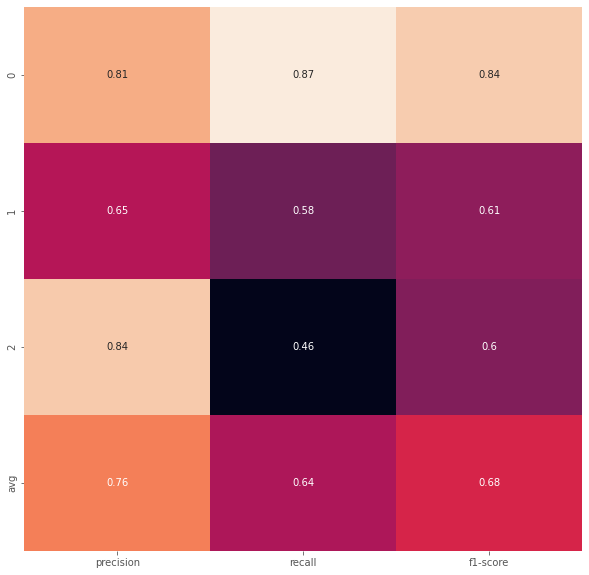

In [79]:

# Score
plot_classification_report(y_test, preds)

# 5. Global regression using XGBoost

In [80]:
y = df[regress_labels]

In [81]:
y.head()

,Liczba pasaz. przed
0,0
1,1
2,1
3,3
4,3


In [82]:
xgb_rg = xgb.XGBRegressor(seed = RANDOM_SEED)
X_train, X_test, y_train, y_test = get_train_and_test_by_lines(df, features, regress_labels)
X_train = full_processor.fit_transform(X_train)
X_test = full_processor.fit_transform(X_test)
y_train = SimpleImputer(strategy="mean").fit_transform(
    y_train.values.reshape(-1, 1)
)
y_test = SimpleImputer(strategy="mean").fit_transform(
    y_test.values.reshape(-1, 1)
)

In [83]:
# Fitting the model
xgb_rg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
# Predict the model
pred = xgb_rg.predict(X_test)

In [85]:
# Errors Computation
absolute_errors = pd.DataFrame(abs(y_test - pred.reshape(-1, 1)))
stats = absolute_errors.describe().round(2)
stats

,0
count,3989.00
mean,4.90
std,5.16
min,0.00
25%,1.55
50%,3.52
75%,6.39
max,60.53


Accuracy: 0.75984


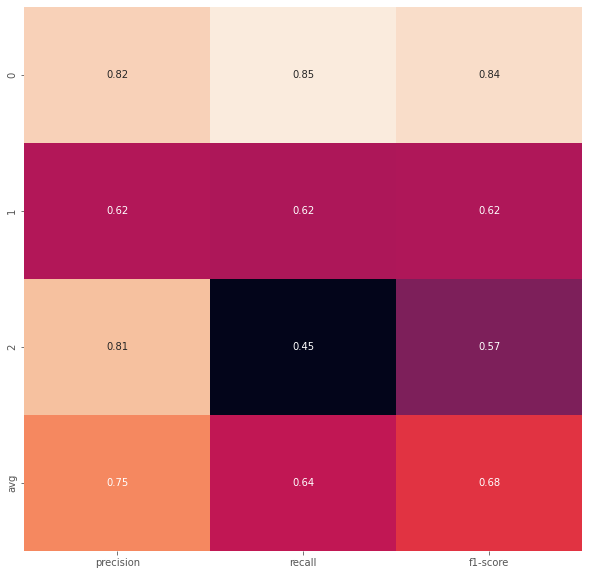

In [86]:
accuracy_of_regression(y_test.reshape(1,-1)[0], np.clip(np.floor(pred), 0, None), clustering_dict)

# 6. Per line binary classification using XGBoost

<https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390>

In [87]:
df.head()

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,Opóźnienie w minutach,class,Numeryczna Nazwa przystanku,Przystanek
0,102,TP-EMP,2022-02-01 05:11:00,1,9415,4,2022-02-01 05:11:00,2022-02-01 05:11:00,0,0,1,1,5.183333,20,0,0,376,37604
1,102,TP-EMP,2022-02-01 05:11:00,1,9415,3,2022-02-01 05:12:00,2022-02-01 05:11:00,1,0,0,1,5.183333,20,1,0,882,88203
2,102,TP-EMP,2022-02-01 05:11:00,1,9415,1,2022-02-01 05:13:00,2022-02-01 05:12:00,1,0,2,3,5.200000,20,1,0,108,10801
3,102,TP-EMP,2022-02-01 05:11:00,1,9415,1,2022-02-01 05:14:00,2022-02-01 05:13:00,3,0,0,3,5.216667,20,1,0,740,74001
4,102,TP-EMP,2022-02-01 05:11:00,1,9415,1,2022-02-01 05:15:00,2022-02-01 05:14:00,3,0,0,3,5.233333,20,1,0,464,46401


In [88]:
features.append('Nr linii')

In [89]:
lines = split_into_lines(df, drop_line = False)

In [90]:
data_lines = dict()
for key, value in lines.items():
    data_lines[key] = get_train_and_test_for_lines(value, X_columns = features, y_columns = class_labels)

In [91]:
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    xgb_cl = xgb.XGBClassifier(seed = RANDOM_SEED)
    X_train, X_test, y_train, y_test = value
    X_train = full_processor.fit_transform(X_train)
    X_test = full_processor.fit_transform(X_test)
    y_train = SimpleImputer(strategy="most_frequent").fit_transform(
        y_train.values.reshape(-1, 1)
    )
    y_test = SimpleImputer(strategy="most_frequent").fit_transform(
        y_test.values.reshape(-1, 1)
    )

    # Fit
    xgb_cl.fit(X_train, y_train)

    # Predict
    preds = xgb_cl.predict(X_test)
    predicted = np.concatenate((predicted, preds), axis=0)
    y_tests = np.concatenate((y_tests, np.concatenate(y_test)), axis=0)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:49:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:49:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:49:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:49:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:50:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:50:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:50:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19:50:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


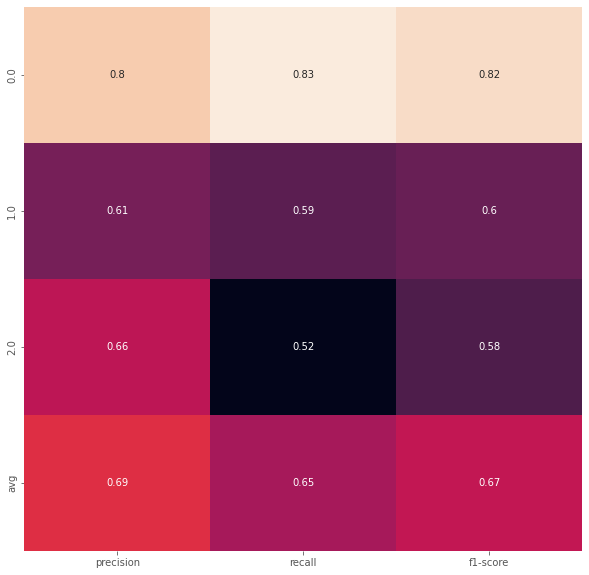

In [92]:

# Score
plot_classification_report(y_tests, predicted)

# 7. Per line regression using XGBoost

In [93]:
data_lines = dict()
for key, value in lines.items():
    data_lines[key] = get_train_and_test_for_lines(value, X_columns = features, y_columns = regress_labels)

In [94]:
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    xgb_cl = xgb.XGBClassifier(seed = RANDOM_SEED)
    X_train, X_test, y_train, y_test = value
    X_train = full_processor.fit_transform(X_train)
    X_test = full_processor.fit_transform(X_test)
    y_train = SimpleImputer(strategy="mean").fit_transform(
        y_train.values.reshape(-1, 1)
    )
    y_test = SimpleImputer(strategy="mean").fit_transform(
        y_test.values.reshape(-1, 1)
    )

    # Fitting the model
    xgb_rg.fit(X_train, y_train)

    # Predict the model
    pred = xgb_rg.predict(X_test)
    predicted = np.concatenate((predicted, pred), axis=0)
    y_tests = np.concatenate((y_tests, np.concatenate(y_test)), axis=0)

In [95]:
# Errors Computation
absolute_errors = pd.DataFrame(abs(y_tests - predicted))
stats = absolute_errors.describe().round(2)
stats

,0
count,3989.00
mean,5.27
std,5.63
min,0.00
25%,1.59
50%,3.72
75%,6.92
max,53.49


Accuracy: 0.73234


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


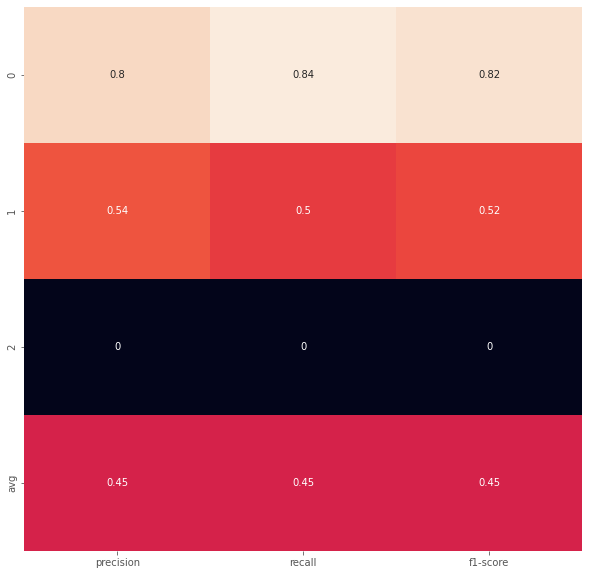

In [96]:
accuracy_of_regression(y_test.reshape(1,-1)[0], np.clip(np.floor(pred), 0, None), clustering_dict)